In [69]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import mlflow
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric

In [70]:
df = pd.read_csv("./data/nba_2022-23_all_stats_with_salary.csv")

In [71]:
df.head()

Unnamed: 0        Player Name    Salary Position  Age     Team  GP  GS  \
0           0      Stephen Curry  48070014       PG   34      GSW  56  56   
1           1          John Wall  47345760       PG   32      LAC  34   3   
2           2  Russell Westbrook  47080179       PG   34  LAL/LAC  73  24   
3           3       LeBron James  44474988       PF   38      LAL  55  54   
4           4       Kevin Durant  44119845       PF   34  BRK/PHO  47  47   

     MP    FG  ...  TOV%  USG%  OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP  
0  34.7  10.0  ...  12.5  31.0  5.8  2.0  7.8  0.192   7.5   0.1  7.5   4.7  
1  22.2   4.1  ...  17.1  27.0 -0.4  0.7  0.3  0.020  -0.8  -0.4 -1.2   0.1  
2  29.1   5.9  ...  18.4  27.7 -0.6  2.6  1.9  0.044   0.3  -0.1  0.2   1.2  
3  35.5  11.1  ...  11.6  33.3  3.2  2.4  5.6  0.138   5.5   0.6  6.1   4.0  
4  35.6  10.3  ...  13.4  30.7  4.7  2.1  6.8  0.194   6.0   1.2  7.1   3.9  

[5 rows x 52 columns]

In [72]:
null_columns = df.columns[df.isnull().any()] 
df[null_columns][df.isnull().any(axis=1)]

FG%    3P%    2P%   eFG%    FT%    TS%   3PAr    FTr
75   0.671    NaN  0.671  0.671  0.484  0.652  0.000  0.436
133  0.680    NaN  0.680  0.680  0.636  0.689  0.000  0.647
221  0.667  0.500  1.000  0.833    NaN  0.833  0.667  0.000
233  0.637    NaN  0.637  0.637  0.691  0.659  0.000  0.386
247  0.000  0.000  0.000  0.000    NaN  0.000  0.500  0.000
254  0.214  0.250  0.000  0.321    NaN  0.321  0.857  0.000
264  0.578    NaN  0.578  0.578  0.357  0.555  0.000  0.340
301  0.819    NaN  0.819  0.819  0.350  0.774  0.000  0.278
332  0.732    NaN  0.732  0.732  0.679  0.739  0.000  0.473
344  0.243  0.348  0.071  0.351    NaN  0.351  0.622  0.000
356  0.150  0.000  0.188  0.150    NaN  0.150  0.200  0.000
358  0.469  0.500  0.444  0.578    NaN  0.578  0.438  0.000
393  0.333  0.200  0.400  0.367    NaN  0.367  0.333  0.000
395  0.635    NaN  0.635  0.635  0.458  0.607  0.000  0.750
397  0.303  0.125  0.471  0.333    NaN  0.333  0.485  0.000
403  0.250  0.250    NaN  0.375    NaN  0.375  1.000  0.000
404  0.400    NaN  0.400  0.400    NaN  0.400  0.000  0.000
408  0.500  0.333  1.000  0.625    NaN  0.625  0.750  0.000
416  0.333  0.375  0.000  0.500    NaN  0.500  0.889  0.000
421  0.667    NaN  0.667  0.667  0.000  0.607  0.000  0.222
425  0.667  0.571  0.750  0.800    NaN  0.800  0.467  0.000
428  0.500    NaN  0.500  0.500  0.000  0.347  0.000  1.000
436    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
437  0.400  0.000  0.667  0.400    NaN  0.400  0.400  0.000
439  1.000    NaN  1.000  1.000    NaN  1.000  0.000  0.000
440  0.800  0.500  1.000  0.900    NaN  0.900  0.400  0.000
441  1.000    NaN  1.000  1.000  1.000  1.064  0.000  2.000
444  0.100  0.250  0.000  0.150    NaN  0.150  0.400  0.000
449  0.333  0.333  0.333  0.389    NaN  0.389  0.333  0.000
453  0.000  0.000  0.000  0.000    NaN  0.000  0.333  0.000
454  0.000  0.000  0.000  0.000    NaN  0.000  0.500  0.000
458  0.500  1.000  0.000  0.750    NaN  0.750  0.500  0.000
459  0.000  0.000    NaN  0.000  1.000  0.532  1.000  2.000
466  0.333  0.333    NaN  0.500    NaN  0.500  1.000  0.000

In [73]:
df[null_columns] = df[null_columns].fillna(0.000) # replace all NaN values with 0.000

In [74]:
df = df.drop(columns=['Unnamed: 0']) 

In [75]:
df.head()

Player Name    Salary Position  Age     Team  GP  GS    MP    FG  \
0      Stephen Curry  48070014       PG   34      GSW  56  56  34.7  10.0   
1          John Wall  47345760       PG   32      LAC  34   3  22.2   4.1   
2  Russell Westbrook  47080179       PG   34  LAL/LAC  73  24  29.1   5.9   
3       LeBron James  44474988       PF   38      LAL  55  54  35.5  11.1   
4       Kevin Durant  44119845       PF   34  BRK/PHO  47  47  35.6  10.3   

    FGA  ...  TOV%  USG%  OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP  
0  20.2  ...  12.5  31.0  5.8  2.0  7.8  0.192   7.5   0.1  7.5   4.7  
1   9.9  ...  17.1  27.0 -0.4  0.7  0.3  0.020  -0.8  -0.4 -1.2   0.1  
2  13.6  ...  18.4  27.7 -0.6  2.6  1.9  0.044   0.3  -0.1  0.2   1.2  
3  22.2  ...  11.6  33.3  3.2  2.4  5.6  0.138   5.5   0.6  6.1   4.0  
4  18.3  ...  13.4  30.7  4.7  2.1  6.8  0.194   6.0   1.2  7.1   3.9  

[5 rows x 51 columns]

In [76]:
df.columns

Index(['Player Name', 'Salary', 'Position', 'Age', 'Team', 'GP', 'GS', 'MP',
       'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'Total Minutes', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP'],
      dtype='object')

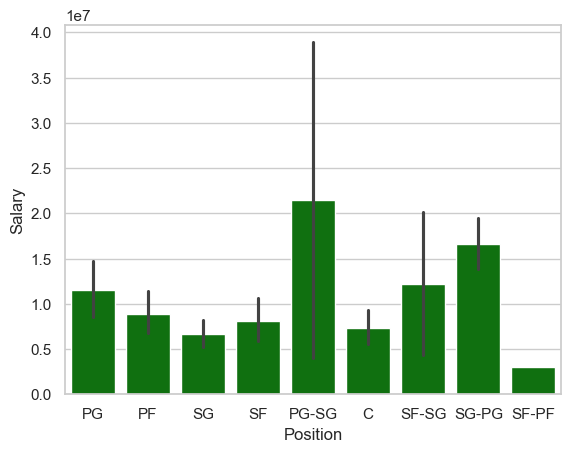

In [9]:
sns.set_theme(style="whitegrid")
sns.barplot(data=df,x='Position',y='Salary', estimator=np.mean, color="green")
plt.show()

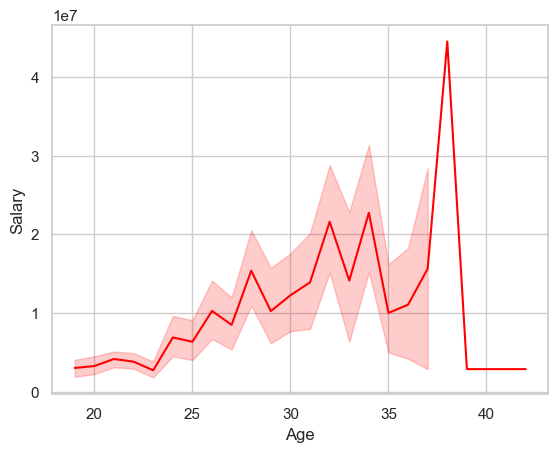

In [39]:
sns.set_theme(style="whitegrid")
sns.lineplot(data=df,x='Age',y='Salary', color="red")
plt.show()

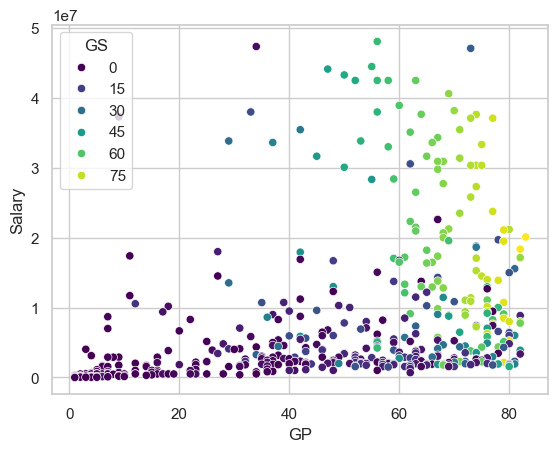

In [68]:
sns.scatterplot(data=df,x="GP",y="Salary",hue="GS", palette="viridis")
plt.show()

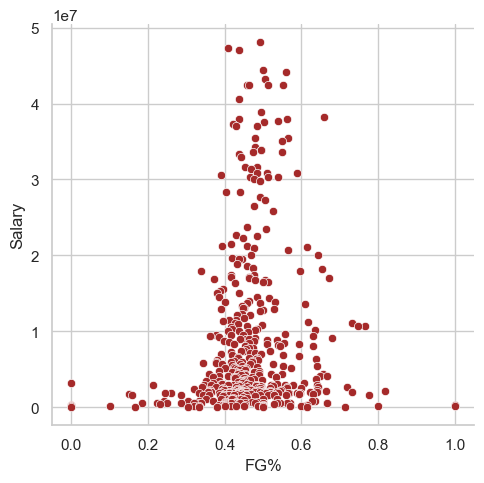

In [71]:
sns.relplot(data=df,x='FG%',y='Salary', color="brown")
plt.show()

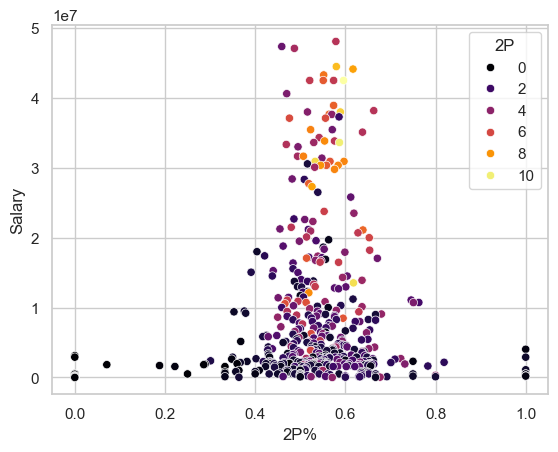

In [73]:
sns.scatterplot(data=df,x="2P%",y="Salary",hue="2P",color="gold", palette="inferno")
plt.show()

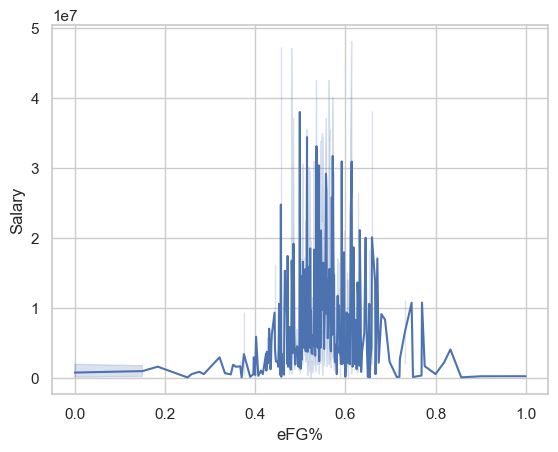

In [74]:
sns.lineplot(data=df,x="eFG%",y="Salary")
plt.show()

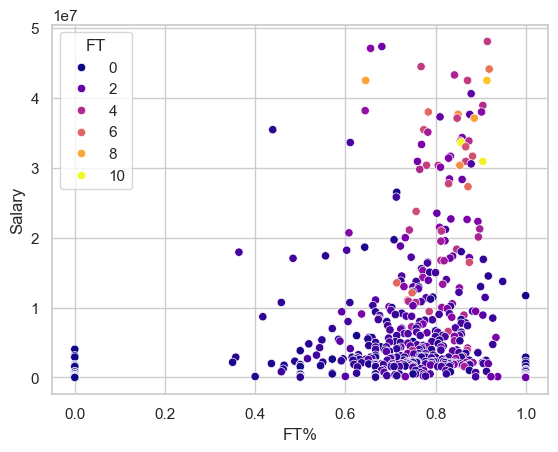

In [75]:
sns.scatterplot(data=df,x="FT%", y="Salary", hue="FT", palette="plasma")
plt.show()

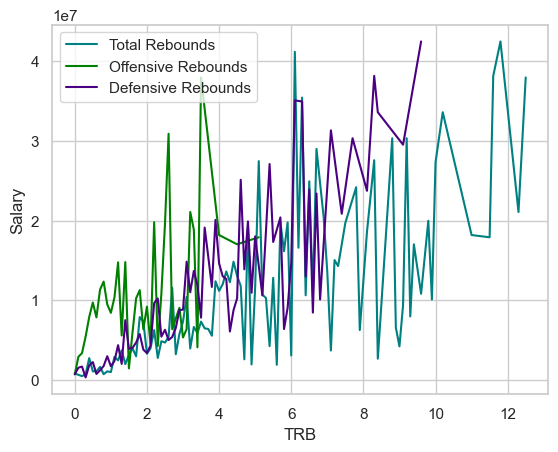

In [95]:
sns.set_theme(style="whitegrid")

sns.lineplot(data=df,x="TRB", y="Salary",errorbar=None, color="teal")
sns.lineplot(data=df,x="ORB", y="Salary", errorbar=None, color="green")
sns.lineplot(data=df,x="DRB", y="Salary", errorbar=None, color="indigo")

plt.legend(["Total Rebounds","Offensive Rebounds", "Defensive Rebounds"])


plt.show()

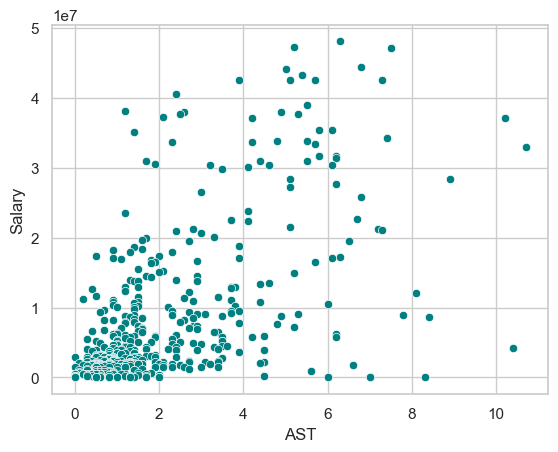

In [100]:
sns.scatterplot(data=df,x="AST", y="Salary", color="teal")
plt.show()

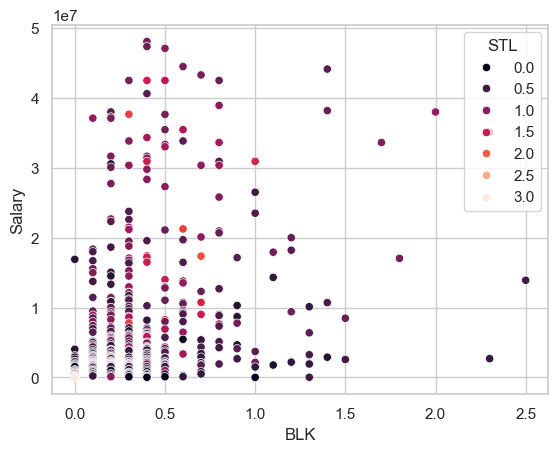

In [99]:
sns.scatterplot(data=df,x="BLK",y="Salary", hue="STL", palette="rocket")
plt.show()

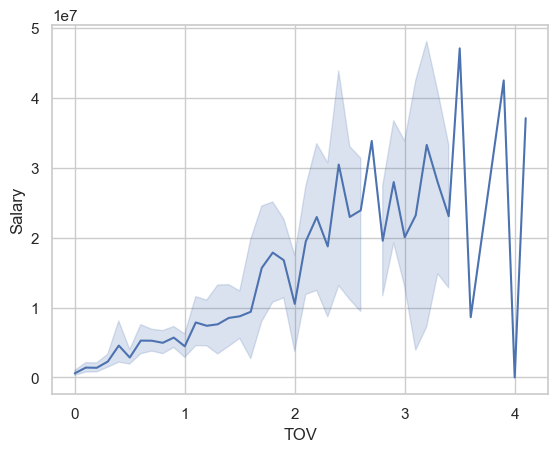

In [102]:
sns.lineplot(data=df,x="TOV",y="Salary")
plt.show()

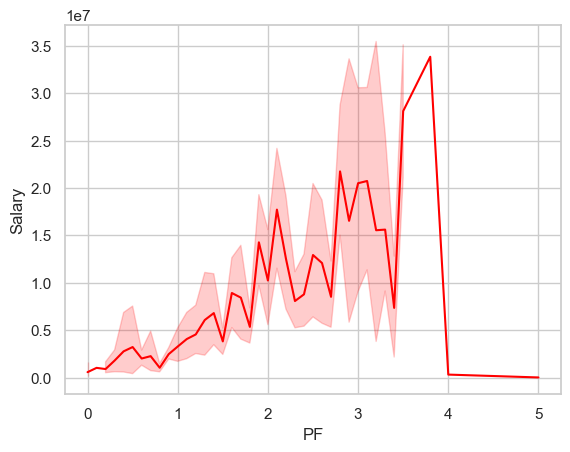

In [105]:
sns.lineplot(data=df,x="PF",y="Salary", color="red")
plt.show()

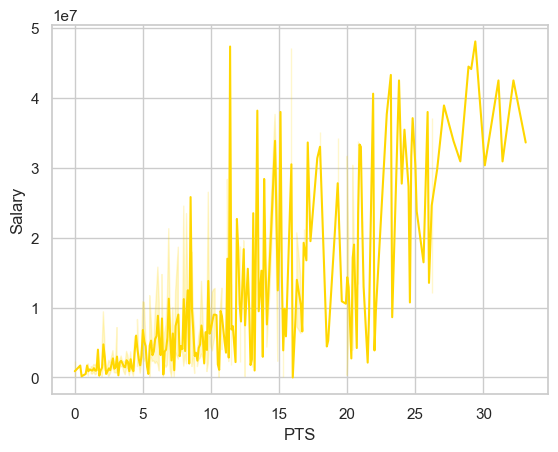

In [107]:
sns.lineplot(data=df,x="PTS",y="Salary", color="gold")
plt.show()

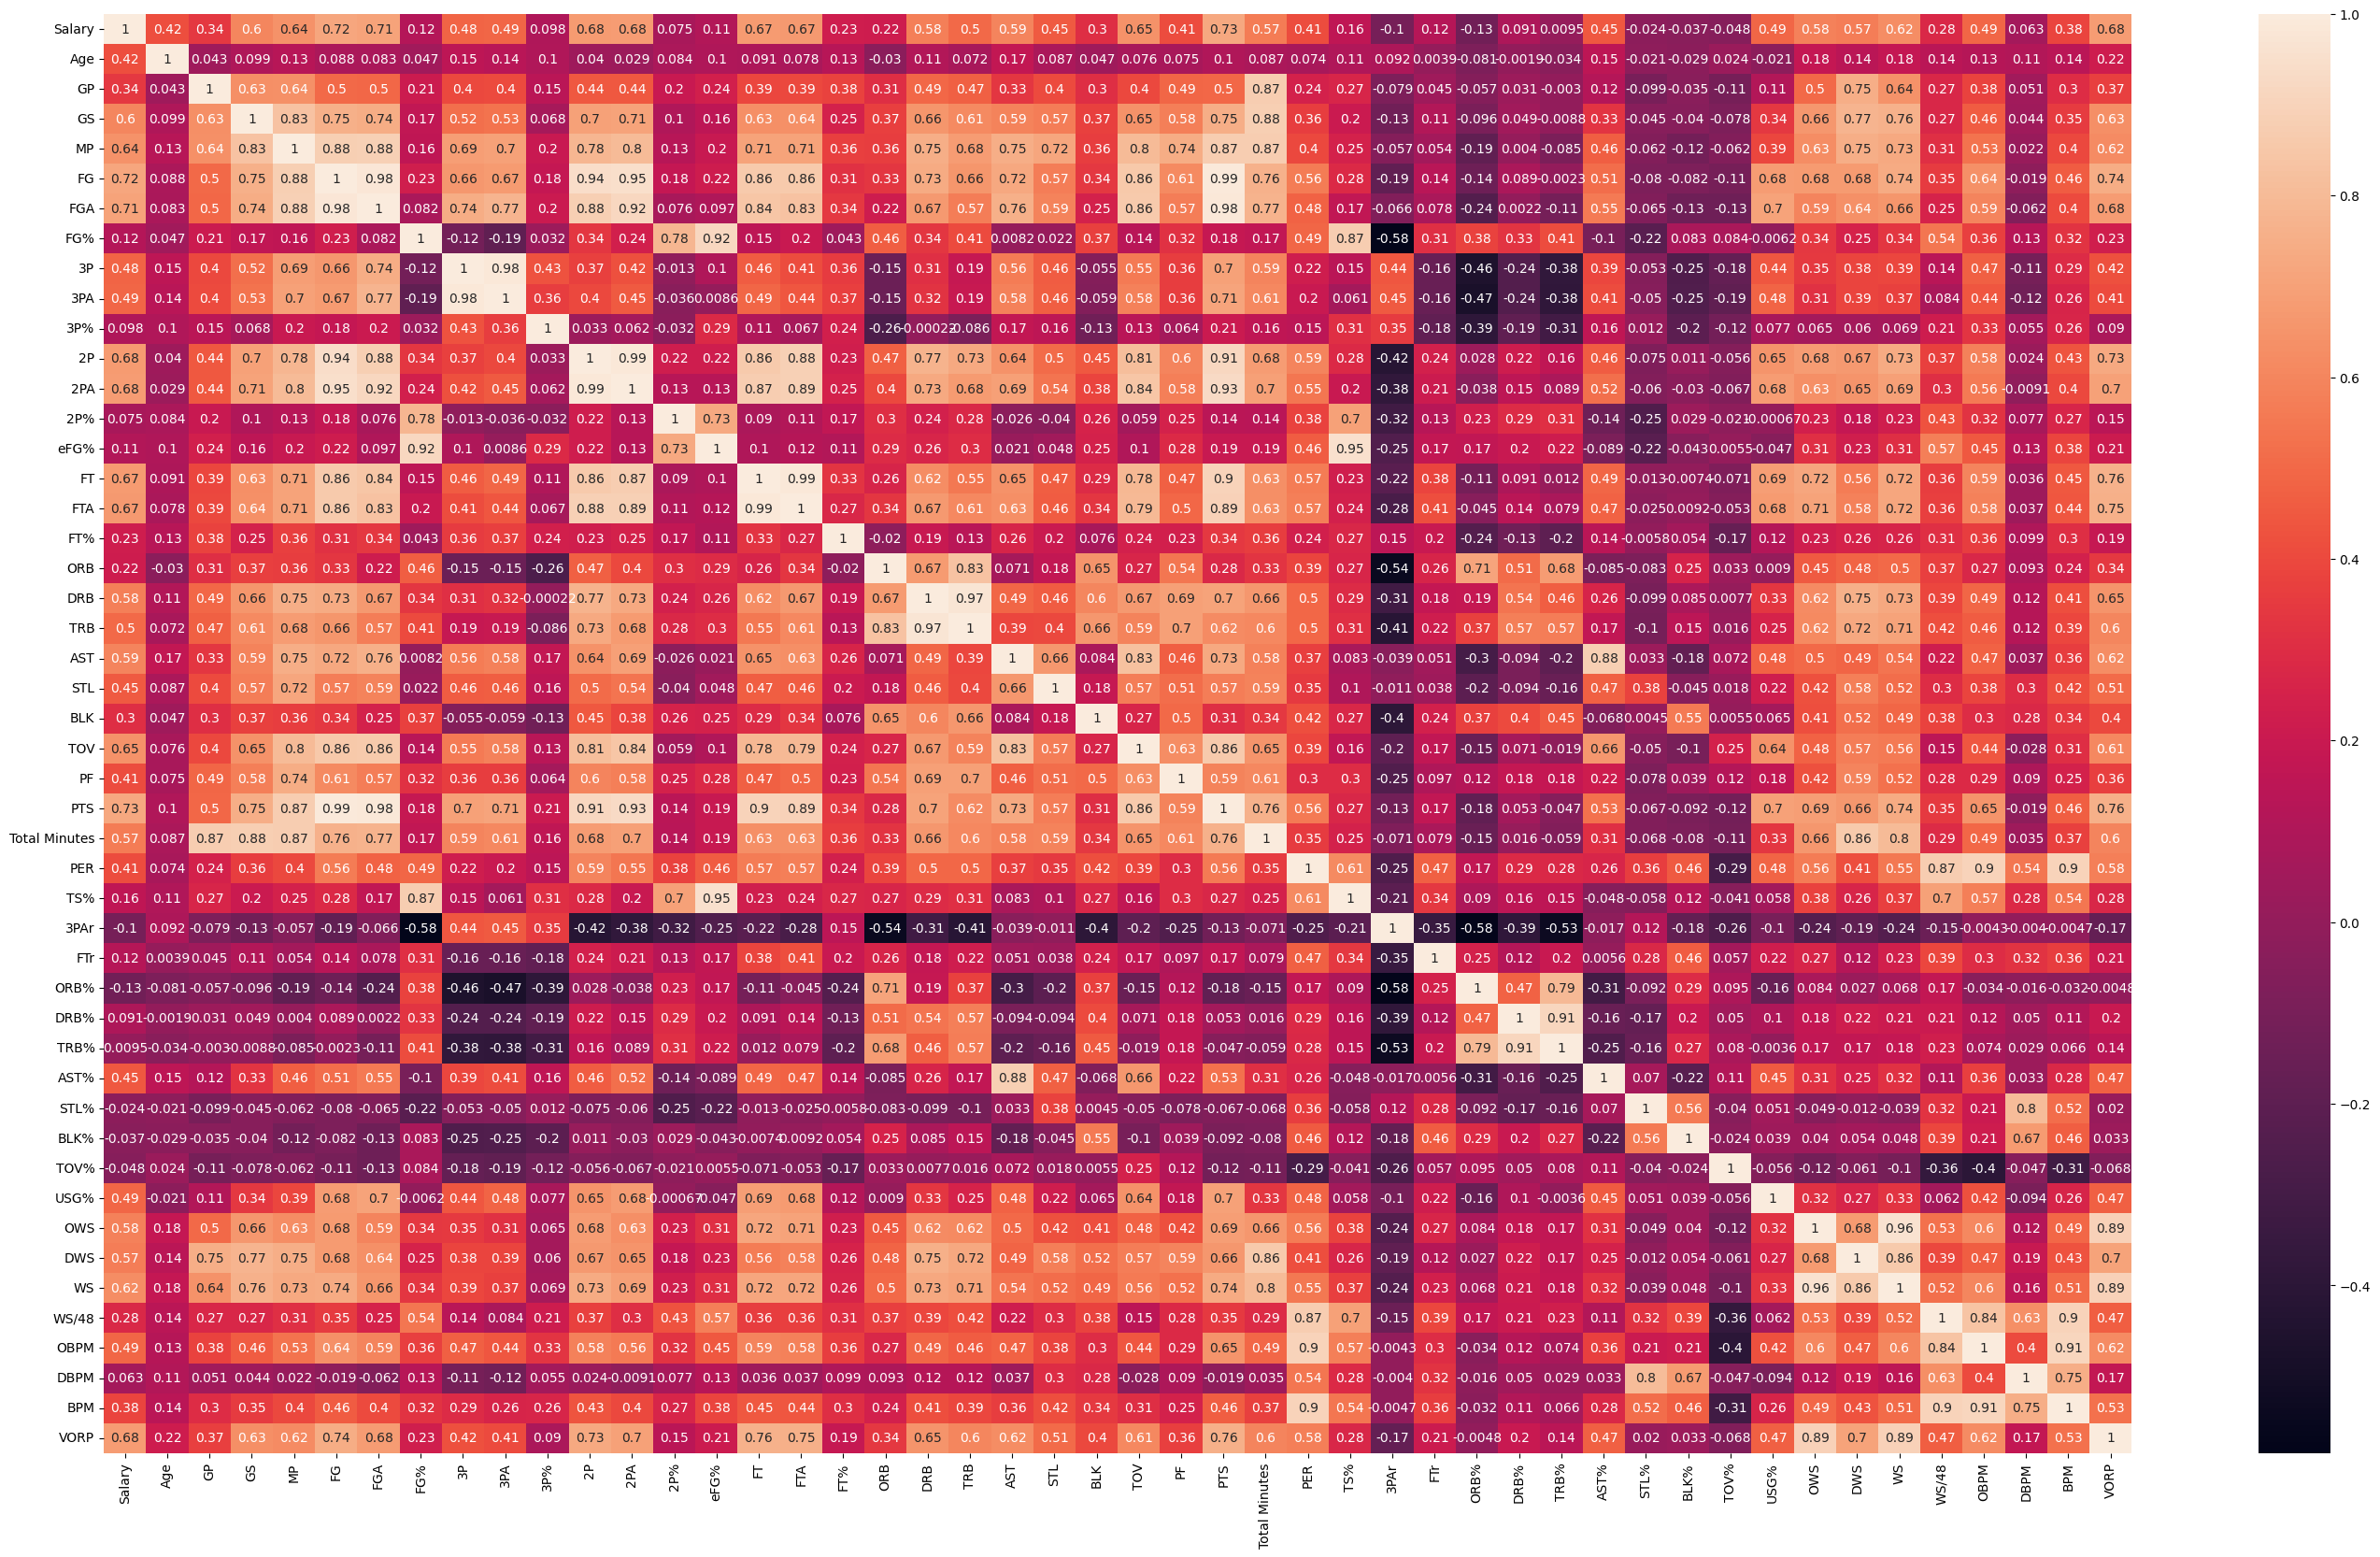

In [45]:
corr = df.select_dtypes(include=["int64","float64"]).corr()

plt.figure(figsize=(35,20))
sns.heatmap(corr,annot=True)
plt.show()

In [77]:
dummies = pd.get_dummies(df["Position"],prefix="position").astype('int')
df = pd.concat([df,dummies],axis=1)
dataframe = df.drop(columns=["Player Name","Position","Team","Salary"])
target = df["Salary"]


In [47]:
dataframe.columns

Index(['Age', 'GP', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Total Minutes', 'PER', 'TS%', '3PAr',
       'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
       'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'position_C', 'position_PF', 'position_PG', 'position_PG-SG',
       'position_SF', 'position_SF-PF', 'position_SF-SG', 'position_SG',
       'position_SG-PG'],
      dtype='object')

In [48]:
X_train, X_test,y_train,y_test = train_test_split(dataframe,target, test_size=0.2, shuffle=True,random_state=42)

In [49]:
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [50]:
def model_metrics(model):   
    y_pred = model.predict(X_test_normalized)
    mae =  mean_absolute_error(y_test,y_pred)# mean absolute error
    rmse = mean_squared_error(y_test,y_pred, squared=False) # root mean squared error
    R2 = r2_score(y_test,y_pred)*100
    
    normalized_rmse = (rmse/(np.max(y_test)-np.min(y_test)))*100
    normalized_mae = (mae/(np.max(y_test)-np.min(y_test)))*100
    
    return {
        "mae": mae,
        "rmse": rmse,
        "r2_score": R2,
        "normalized_rmse": normalized_rmse,
        "normalized_mae": normalized_mae
    }
    

In [51]:
params = {'n_estimators': 1800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 1.0, 'bootstrap': True}

random_forest = RandomForestRegressor(**params)#test3
random_forest.fit(X_train_normalized, y_train)
model_metrics(random_forest)

{'mae': 3694213.2346638306,
 'rmse': 5392103.769531011,
 'r2_score': 78.09991643419463,
 'normalized_rmse': 11.2247000131355,
 'normalized_mae': 7.690214639037457}

In [34]:
params = {
    "n_estimators": 11000,
    "max_depth": 5,
    "min_samples_split": 2,
    "learning_rate": 0.05,
    "loss": "huber",
    "random_state":42
}

gb_regressor = GradientBoostingRegressor(**params)
gb_regressor.fit(X_train_normalized,y_train)
model_metrics(gb_regressor)

{'mae': 3882339.8971877987,
 'rmse': 5817627.120516081,
 'r2_score': 74.50699373871889,
 'normalized_rmse': 12.110508626534463,
 'normalized_mae': 8.08183643297181}

In [16]:
params = {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 8, 'gamma': 5, 'colsample_bytree': 1.0}
xgboost_regressor = XGBRegressor(**params)
xgboost_regressor.fit(X_train_normalized, y_train)
model_metrics(xgboost_regressor)

{'mae': 4130641.5319148935,
 'rmse': 6356218.041386492,
 'r2_score': 69.56825456239561,
 'normalized_rmse': 13.231689110992123,
 'normalized_mae': 8.598723993321043}

In [24]:
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

grid_search = GridSearchCV(estimator=xgboost_regressor, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

In [ ]:
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': [1.0, 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Instantiate the random forest regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Instantiate the randomized search model
rand_search = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_dist, cv=5, n_iter=100, n_jobs=-1)

# Fit the randomized search model
rand_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", rand_search.best_params_)

In [52]:
with open('models/nba_salaries_predictor_v1.bin', 'wb') as file:
    pickle.dump(random_forest, file)

In [54]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("my-nba-salary-experiment")


<Experiment: artifact_location='mlflow-artifacts:/8', creation_time=1706205727444, experiment_id='8', last_update_time=1706205727444, lifecycle_stage='active', name='my-nba-salary-experiment', tags={}>

In [55]:
with mlflow.start_run():
    params = {'n_estimators': 1800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 1.0, 'bootstrap': True}

    mlflow.log_params(params)
    
    random_forest = RandomForestRegressor(**params)
    random_forest.fit(X_train_normalized, y_train)
    
    y_pred = random_forest.predict(X_test_normalized)
    
    mae =  mean_absolute_error(y_test,y_pred)# mean absolute error
    rmse = mean_squared_error(y_test,y_pred, squared=False) # root mean squared error
    R2 = r2_score(y_test,y_pred)*100
    
    mlflow.log_metric("rmse",rmse)
    mlflow.log_metric("mae",mae)

    normalized_rmse = (rmse/(np.max(y_test)-np.min(y_test)))*100
    normalized_mae = (mae/(np.max(y_test)-np.min(y_test)))*100
    
    mlflow.log_metric("normalized_rmse",normalized_rmse)
    mlflow.log_metric("normalized_mae", normalized_mae)
    mlflow.log_metric("r2_score",R2)
    
    mlflow.log_artifact(local_path="./data/nba_2022-23_all_stats_with_salary.csv",artifact_path="artifacts")
    mlflow.sklearn.log_model(random_forest, artifact_path="models")
    

In [78]:
df.shape

(467, 60)

In [85]:
target = "Salary"

num_features = ['Age','GP', 'GS', 'MP','FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%','FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV','PF', 'PTS', 'Total Minutes', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%','DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS','WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

cat_features = ['position_C','position_PF', 'position_PG', 'position_PG-SG', 'position_SF', 'position_SF-PF', 'position_SF-SG', 'position_SG', 'position_SG-PG']

In [86]:
train_data = df[233:]
val_data = df[:233]

In [87]:
params = {'n_estimators': 1800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 1.0, 'bootstrap': True}

model = RandomForestRegressor(**params)
model.fit(train_data[num_features+cat_features],train_data[target])

RandomForestRegressor(min_samples_leaf=2, min_samples_split=5,
                      n_estimators=1800)

In [88]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data.loc[:,'prediction'] = train_preds

In [89]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data.loc[:,'prediction'] = val_preds

In [90]:
print(mean_absolute_error(train_data.Salary, train_data.prediction))
print(mean_absolute_error(val_data.Salary,val_data.prediction))

240905.45065216548
12921752.1242387


In [94]:
column_mapping = ColumnMapping(
    target=None,
    prediction= "prediction",
    numerical_features= num_features,
    categorical_features= cat_features
)

In [95]:
report  = Report(metrics=[
    ColumnDriftMetric(column_name='prediction'),
    DatasetDriftMetric(),
    DatasetMissingValuesMetric()
])

In [96]:
report.run(reference_data=train_data, current_data=val_data,column_mapping=column_mapping)

In [97]:
report.show(mode='inline')